In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
%%html
<style>
table {float:left}
</style>

In this example, we used two datasets of pancreatic cells. For gene markers, we used the Panglao Cell Type Marker database.

We used the Baron (2016) dataset for training the neural network (NN) because it has more cells and classes, and we used the Xin (2016) dataset for testing purposes because all of its classes are present in the Baron dataset.

In [3]:
EPOCHS = 100

In [4]:
import saly
import saly.backend as S
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


SPECIES = 'Human'
DATA_PATH = '/Users/MarkDavidLongar/Documents/Coding/MachineLearning/Data/'
DATASET_BARON_PATH = DATA_PATH + 'baron_2016h.h5ad' 
DATASET_XIN_PATH = DATA_PATH + 'xin_2016.h5ad'
MARKER_PATH = DATA_PATH + 'panglao_gene_markers.tab.gz'

Using TensorFlow backend.


# Load the data

In [5]:
baron_data, baron_labels = saly.load_h5ad(DATASET_BARON_PATH)
xin_data, xin_labels = saly.load_h5ad(DATASET_XIN_PATH)

### Baron

In [6]:
print(baron_data.shape)
baron_labels.unique()

(8569, 20125)


[Acinar cells, Beta cells, Delta cells, PaSC, Ductal cells, Alpha cells, Other, PP cells, Endothelial cell]
Categories (9, object): [Acinar cells, Beta cells, Delta cells, PaSC, ..., Alpha cells, Other, PP cells, Endothelial cell]

Baron has 8569 cells and 20125 genes.

The cells are classified into 9 classes: Acinar cells, Alpha cells, Beta cells, Delta cells, Ductal cells, Endothelial cells, ***Other***, PaSC (i.e. Pancreatic stellate cells) and PP cells (i.e. Gamma cells).

### Xin

In [7]:
print(xin_data.shape)
xin_labels.unique()

(1492, 39851)


[Beta cells, Alpha cells, Delta cells, PP cells]
Categories (4, object): [Beta cells, Alpha cells, Delta cells, PP cells]

Xin has 1492 cells and 39851 genes.

The cells are classified into 4 classes: Alpha cells, Beta cells, Delta cells and PP cells (i.e. Gamma cells).

# Drop rows

We removed every cell classified as 'Other' from the Baron dataset.

In [8]:
baron_data, baron_labels = saly.drop_rows(baron_data, baron_labels, ['Other'])

Dropped 118 cell(s). New shape: (8451, 20125)


This removed 118 cells from Baron, leaving us with 8451 left.

# Load marker genes

We make sure to only load the Human marker genes.

In [9]:
markers_db = saly.load_markers(MARKER_PATH, SPECIES)

#### Get the markers and only keep those found in both datasets

In [10]:
markers = saly.get_mutual_markers([baron_data.columns, xin_data.columns], markers_db)

We do this because we want to train the network only on the marker genes found in both datasets, and drop the rest.

In [11]:
#print(len(S.get_used_markers(baron_data.columns, markers_db)), len(S.get_used_markers(xin_data.columns, markers_db)))
print(len(markers))

7545


Baron has 7618 markers, and Xin has 7610.

We used only those found in both datasets (7545).

*Note that in this context* ***Marker ≠ Marker Gene*** *because multiple cell types (i.e. markers) can have the same marker gene and so in this context, the number 7545 means 7545 connections in the partially-connected Marker Layer between the cell types and the genes.*

### Make sure every class is in the marker layer

Because some cell types are differently labelled in the marker database, we created a dictionary of aliases.

We also make sure to print out any label that cannot be found in either the list of markers or in the dictionary of aliases.

In [12]:
marker_aliases = {'PaSC' : 'Pancreatic stellate cells',
                  'PP cells' : 'Gamma (PP) cells',
                  'Endothelial cell' : 'Endothelial cells'}

saly.check_labels([baron_labels, xin_labels], markers, marker_aliases)

# Drop unused genes

We used only the genes found in both datasets and the marker gene database, and therefore, we will connect with the partially-connected marker layer.

In [13]:
baron_data = saly.drop_unused_genes(baron_data, markers)
xin_data = saly.drop_unused_genes(xin_data, markers)

Dropped 15952 gene(s). New shape: (8451, 4173)
Dropped 35678 gene(s). New shape: (1492, 4173)


After this operation we are left with 4173 genes.

#### Make sure the data sets' shapes match

In [14]:
saly.check_shape([baron_data, xin_data])

# Data transformation

#### Preprocess the data

We shuffle, log10 transform and split the data into 70%, 15%, 15% splits.

In [15]:
(train_x, train_y), (validation_x, validation_y), (test_x, test_y) = saly.preprocess_data(baron_data, baron_labels,
                                                                                          train=0.7, validation=0.15,
                                                                                          test=0.15)

#### Log10 transform the Xin data, too

In [16]:
xin_data = S.log_10(xin_data)

# Building the model

For the model we define a partially-connected Marker Layer.

The layer has a node for each cell type whose genes are present in both data sets.
In this case, there are 179 nodes in the marker layer representing 179 cell types. 

We only connect nodes (i.e. the cell types) in the marker layer to their marker genes at the input.

We constructed the partially connected marker layer by taking a dense layer and adding a connection mask (a binary matrix) to it, which we multiply with the output matrix.

We trained the network for 100 epochs.

### The Architecture
|Layer|Nodes|
|-----|------|
|Input|4173 (genes)|
|Markers|179 (cell types)|
|Dense layer|100|
|**Bottleneck**|**25**|
|Dense layer|100|
|*Dropout*|*10%*|
|Output|4173 (genes)|

#### Create the model

In [17]:
model, marker_model, encoder_model = saly.build_model(baron_data, markers);

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4173)              0         
_________________________________________________________________
markers_1 (Markers)          (None, 179)               747146    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               18000     
_________________________________________________________________
Bottleneck (Dense)           (None, 25)                2525      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
Output (Dense)               (None, 4173)              421473    
Total para

# Train the model

In [36]:
history = saly.train_model(model, train_x, EPOCHS, validation_data=validation_x, verbose=0);

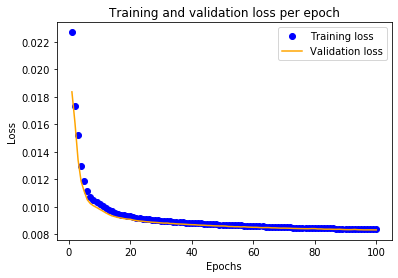

Test loss:  0.008359335224828698


In [37]:
saly.plot_model_history(history)
print("Test loss: ", saly.test_model(model, test_x))

## Save the model

In [21]:
saly.load_weights(model, 'Data/Models/model_weights')
saly.load_weights(marker_model, 'Data/Models/marker_weights')
saly.load_weights(encoder_model, 'Data/Models/encoder_weights')

# Data analysis

In [26]:
from sklearn.manifold import TSNE
tnse = TSNE()
colours = S.load_label_colours('Data/label_colours.pickle')

## Baron predictions

In [22]:
baron_cell_activations = marker_model.predict(test_x)
baron_bottleneck_activations = encoder_model.predict(test_x)

Spodnji graf prikazuje aktivacije tipov celic. Razvidno je, da izstopa samo en celični tip, ostali tipi pa izrecno manj.

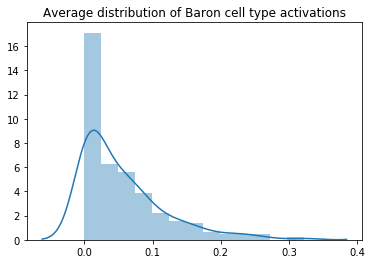

In [23]:
saly.plot_activation_distribution(baron_cell_activations, markers,
                                  title='Average distribution of Baron cell type activations')

In [24]:
saly.get_results(test_y, baron_cell_activations, markers, marker_aliases)

Correct predictions: 222 out of 2536 (8.75%)


**Mreža pravilno klasificira 82% testnih podatkov (iz baze na kateri se je učila)**

In [30]:
saly.draw_embedding(baron_cell_activations, test_y, tnse, colours, graph_title='TSNE of Baron cell type activations')

TypeError: draw_embedding() got an unexpected keyword argument 'graph_name'

## Xin predictions

In [27]:
xin_cell_activations = marker_model.predict(xin_data)

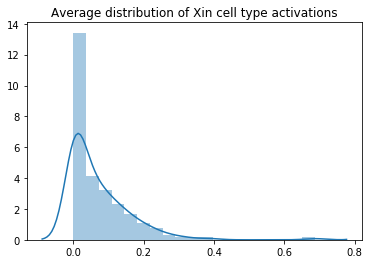

In [28]:
saly.plot_activation_distribution(xin_cell_activations, markers,
                                  title='Average distribution of Xin cell type activations')

In [29]:
saly.get_results(xin_labels, xin_cell_activations, markers, marker_aliases)

Correct predictions: 470 out of 1492 (31.5%)


**Mreža pravilno klasificira 86% čisto novih podatkov iz druge baze**

<Figure size 432x288 with 0 Axes>

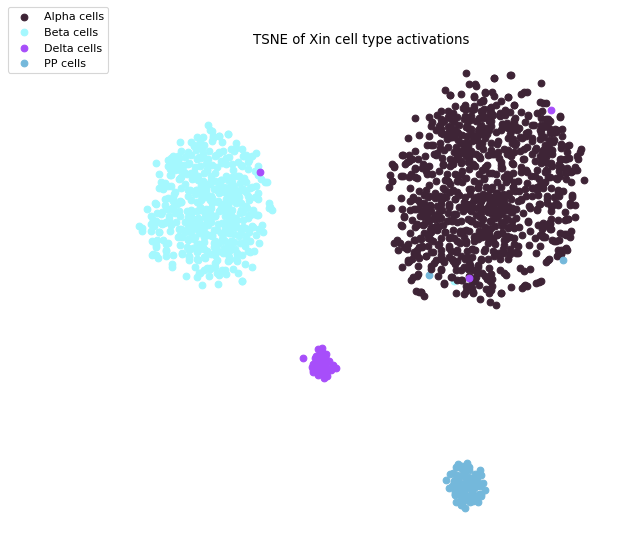

In [46]:
saly.draw_embedding(xin_cell_activations, xin_labels, tnse, colours, graph_title='TSNE of Xin cell type activations')

# Reconstruction

**Tukaj sem vzel nove podatke in jih vrgel v avtoenkoder.**

**Nato sem vzel izhodne podatke avtoenkoderja ter vzel njihove aktivacije sloja markerjev.**

**Tako sem dobil nove rezultate, ki so bili konsistentno boljši. V tem primeru za 11%.**

Moja hipoteza je, da se tako delno znebimo batch effecta in zato dobimo boljše rezultate.

In [47]:
reconstruction = model.predict(xin_data)
reconstruction = pd.DataFrame(reconstruction, columns=xin_data.columns)
reconstructed_cell_activations = marker_model.predict(reconstruction)

In [48]:
saly.get_results(xin_labels, reconstructed_cell_activations, markers, marker_aliases)

Correct predictions: 1420 out of 1492 (95.17%)


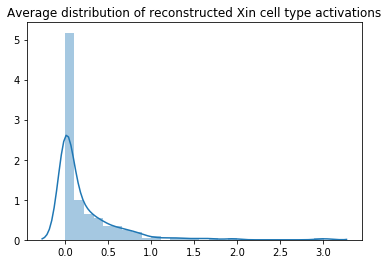

In [49]:
saly.plot_activation_distribution(reconstructed_cell_activations, markers,
                                  title='Average distribution of reconstructed Xin cell type activations')

<Figure size 432x288 with 0 Axes>

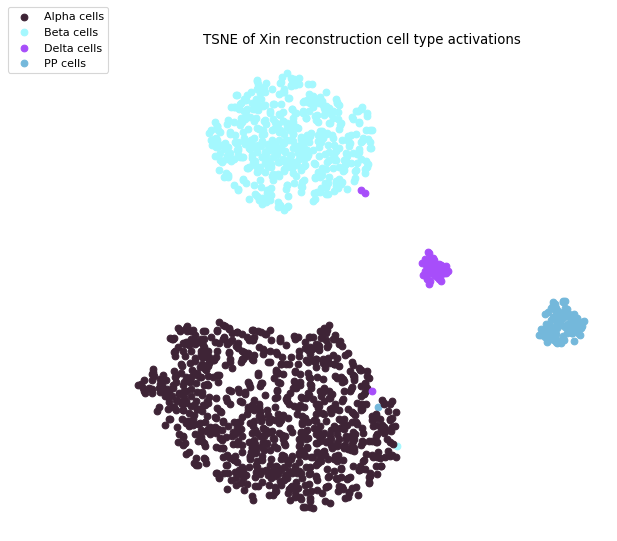

In [50]:
saly.draw_embedding(reconstructed_cell_activations, xin_labels, tnse, colours,
           graph_title='TSNE of Xin reconstruction cell type activations')

Tudi pri teh podatkih batch effect še vedno ostane.

In [52]:
!ls 

Data  Example.ipynb  Notebooks	README.md  saly


In [51]:
model.save_weights('Data/Models/model_weights.h5')
encoder_model.save_weights('Data/Models/encoder_weights.h5')
marker_model.save_weights('Data/Models/marker_weights.h5')

OSError: Unable to create file (unable to open file: name = 'Data/Models/model_weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

# Combined data

In [ ]:
def draw_comparison(x, y, title=''):
    plt.clf()
    plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

    for i, entry in enumerate(tsne_out):
        colour = colours[y.iloc[i]]
        alpha = 1.0
        marker = '.'
        if(i <= test_x.shape[0]):
            alpha = new_alpha
            marker = 'x'
        plt.scatter(entry[0], entry[1], color=colour, label=y.iloc[i], alpha=alpha, marker=marker)

    handles, plt_labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(plt_labels, handles))
    by_label = OrderedDict(sorted(by_label.items()))

    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0., 1, 0, .1))

    plt.title(title)
    plt.axis('off')
    plt.show()

**Na spodnjem grafu lahko opaziš, da se batch effect še vedno opazi, tudi na aktivacijah markerjev**

In [ ]:
x = test_x.append(new_data_x)
y = test_y.append(new_labels)
compare_cell_activations = encoder_model.predict(x)
tsne_out = draw_comparison(compare_cell_activations, y, new_alpha=0.2, title='Combined TSNE of marker activations')

In [ ]:
draw_comparison(np.vstack((top3, new_top3)), y, new_alpha=0.2, title='Combined TSNE of top 3 activations')

In [ ]:
x = test_x.append(reconstruction)
y = test_y.append(new_labels)
compare_cell_activations = encoder_model.predict(x)
tsne_out = draw_comparison(compare_cell_activations, y, new_alpha=0.2, title='Combined TSNE of marker activations')